/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

RNN Detailed Metrics:
Accuracy:   0.8506
Precision: 0.8784
Recall:    0.7970
F1 Score:  0.8357

Confusion Matrix:
[[2694  301]
 [ 554 2175]]

Confusion Matrix Interpretation:
True Negatives:  2694
False Positives: 301
False Negatives: 554
True Positives:  2175
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

LSTM Detailed Metrics:
Accuracy:   0.8545
Precision: 0.8294
Recall:    0.8747
F1 Score:  0.8514

Confusion Matrix:
[[2504  491]
 [ 342 2387]]

Confusion Matrix Interpretation:
True Negatives:  2504
False Positives: 491
False Negatives: 342
True Positives:  2387
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step

BiLSTM Detailed Metrics:
Accuracy:   0.8552
Precision: 0.8359
Recall:    0.8663
F1 Score:  0.8508

Confusion Matrix:
[[2531  464]
 [ 365 2364]]

Confusion Matrix Interpretation:
True Negatives:  2531
False Positives: 464
False 

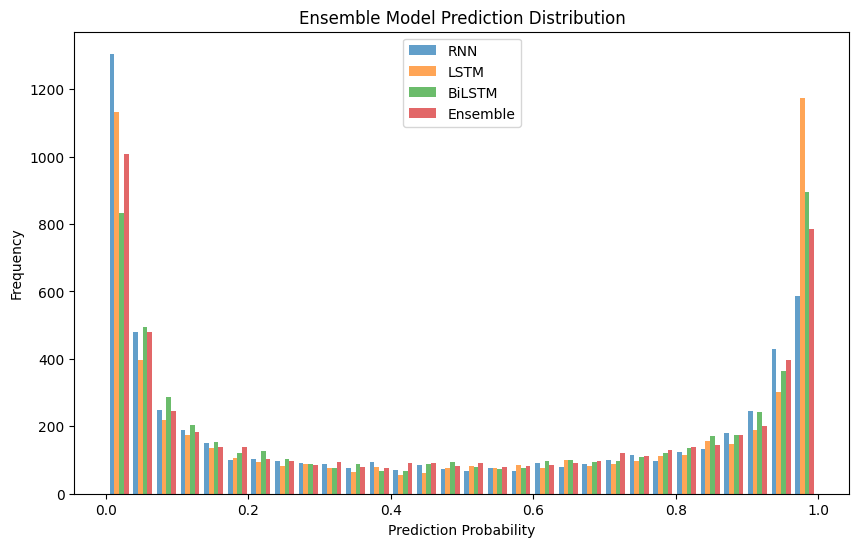

In [ ]:
import json
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Bidirectional, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

# Load and preprocess the data
with open('Sarcasm_Headlines_Dataset.json') as f:
    data = [json.loads(line) for line in f]

df = pd.DataFrame(data)
df = df[['headline', 'is_sarcastic']]

# Tokenize and pad sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['headline'])
sequences = tokenizer.texts_to_sequences(df['headline'])
X = pad_sequences(sequences, maxlen=30)  # maxlen chosen to fit most headlines
y = df['is_sarcastic'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create individual models
def create_rnn_model():
    rnn_model = Sequential([
        Embedding(len(tokenizer.word_index) + 1, 64, input_length=30),
        SimpleRNN(64),
        Dense(1, activation='sigmoid')
    ])
    rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return rnn_model

def create_lstm_model():
    lstm_model = Sequential([
        Embedding(len(tokenizer.word_index) + 1, 64, input_length=30),
        LSTM(64),
        Dense(1, activation='sigmoid')
    ])
    lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return lstm_model

def create_bilstm_model():
    bilstm_model = Sequential([
        Embedding(len(tokenizer.word_index) + 1, 64, input_length=30),
        Bidirectional(LSTM(64)),
        Dense(1, activation='sigmoid')
    ])
    bilstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return bilstm_model

# Train individual models
rnn_model = create_rnn_model()
lstm_model = create_lstm_model()
bilstm_model = create_bilstm_model()

# Training with early stopping and reduced epochs to demonstrate
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

rnn_history = rnn_model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=0
)

lstm_history = lstm_model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=0
)

bilstm_history = bilstm_model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=0
)

# Ensemble Prediction Function (Soft Voting)
def ensemble_predict(models, X, threshold=0.5):
    # Get predictions from each model
    predictions = [model.predict(X) for model in models]

    # Average the predictions
    avg_predictions = np.mean(predictions, axis=0)

    # Apply threshold
    return (avg_predictions > threshold).astype(int)

# Ensemble Models
models = [rnn_model, lstm_model, bilstm_model]

# Predict and evaluate ensemble
y_pred_ensemble = ensemble_predict(models, X_test)

# Detailed Evaluation Metrics
def print_detailed_metrics(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n{model_name} Detailed Metrics:")
    print(f"Accuracy:   {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    print("\nConfusion Matrix Interpretation:")
    print(f"True Negatives:  {cm[0][0]}")
    print(f"False Positives: {cm[0][1]}")
    print(f"False Negatives: {cm[1][0]}")
    print(f"True Positives:  {cm[1][1]}")

# Print results for individual models and ensemble
individual_models = [
    (rnn_model, "RNN"),
    (lstm_model, "LSTM"),
    (bilstm_model, "BiLSTM")
]

for model, name in individual_models:
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    print_detailed_metrics(y_test, y_pred, name)

print_detailed_metrics(y_test, y_pred_ensemble, "Ensemble")

# Visualization of Ensemble Prediction Distribution
plt.figure(figsize=(10, 6))
plt.title("Ensemble Model Prediction Distribution")
plt.hist([rnn_model.predict(X_test).flatten(),
          lstm_model.predict(X_test).flatten(),
          bilstm_model.predict(X_test).flatten(),
          np.mean([rnn_model.predict(X_test),
                   lstm_model.predict(X_test),
                   bilstm_model.predict(X_test)], axis=0).flatten()],
         label=['RNN', 'LSTM', 'BiLSTM', 'Ensemble'],
         bins=30, alpha=0.7)
plt.xlabel("Prediction Probability")
plt.ylabel("Frequency")
plt.legend()
plt.show()

179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

RNN Detailed Metrics:
Accuracy:   0.8506
Precision: 0.8784
Recall:    0.7970
F1 Score:  0.8357

Confusion Matrix:
[[2694  301]
 [ 554 2175]]

Confusion Matrix Interpretation:
True Negatives:  2694
False Positives: 301
False Negatives: 554
True Positives:  2175
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

LSTM Detailed Metrics:
Accuracy:   0.8545
Precision: 0.8294
Recall:    0.8747
F1 Score:  0.8514

Confusion Matrix:
[[2504  491]
 [ 342 2387]]

Confusion Matrix Interpretation:
True Negatives:  2504
False Positives: 491
False Negatives: 342
True Positives:  2387
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step

BiLSTM Detailed Metrics:
Accuracy:   0.8552
Precision: 0.8359
Recall:    0.8663
F1 Score:  0.8508

Confusion Matrix:
[[2531  464]
 [ 365 2364]]

Confusion Matrix Interpretation:
True Negatives:  2531
False Positives: 464
False Negatives: 365
True Positives:  2364

Ensemble Detailed Metrics:
Accuracy:   0.8601
Precision: 0.8526
Recall:    0.8542
F1 Score:  0.8534

Confusion Matrix:
[[2592  403]
 [ 398 2331]]

Confusion Matrix Interpretation:
True Negatives:  2592
False Positives: 403
False Negatives: 398
True Positives:  2331
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step

In [ ]:
import json
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Bidirectional, Dense, Dropout, GlobalMaxPooling1D, Conv1D
from tensorflow.keras.regularizers import l2  # Correct import for regularization
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Data Preprocessing Improvements
def preprocess_data(max_words=5000, maxlen=50):
    # Load and preprocess the data
    with open('Sarcasm_Headlines_Dataset.json') as f:
        data = [json.loads(line) for line in f]

    df = pd.DataFrame(data)
    df = df[['headline', 'is_sarcastic']]

    # Tokenize with limited vocabulary
    tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
    tokenizer.fit_on_texts(df['headline'])

    # Convert to sequences
    sequences = tokenizer.texts_to_sequences(df['headline'])

    # Pad sequences with increased length
    X = pad_sequences(sequences, maxlen=maxlen, truncating='post', padding='post')
    y = df['is_sarcastic'].values

    return X, y, tokenizer

# Enhanced Model Architectures
def create_enhanced_model(vocab_size, embedding_dim=128, maxlen=50):
    model = Sequential([
        # Enhanced Embedding Layer
        Embedding(vocab_size, embedding_dim, input_length=maxlen,
                  embeddings_regularizer=l2(0.001)),

        # Add Convolutional Layer for Feature Extraction
        Conv1D(64, 5, activation='relu', padding='same'),
        GlobalMaxPooling1D(),

        # Dropout for Regularization
        Dropout(0.5),

        # Multiple Dense Layers
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.4),
        Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.3),

        # Output Layer
        Dense(1, activation='sigmoid')
    ])

    # Advanced Optimization
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Advanced Ensemble with Model Stacking
def create_stacked_ensemble(X_train, y_train, X_test, y_test):
    # Base Models
    base_models = [
        create_enhanced_model(len(tokenizer.word_index) + 1),
        create_enhanced_model(len(tokenizer.word_index) + 1),
        create_enhanced_model(len(tokenizer.word_index) + 1)
    ]

    # Train base models
    base_predictions = []
    for i, model in enumerate(base_models):
        print(f"Training Base Model {i+1}")
        history = model.fit(
            X_train, y_train,
            validation_split=0.1,
            epochs=15,
            batch_size=64,
            verbose=1,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(
                    monitor='val_accuracy',
                    patience=5,
                    restore_best_weights=True
                ),
                tf.keras.callbacks.ReduceLROnPlateau(
                    monitor='val_loss',
                    factor=0.5,
                    patience=3
                )
            ]
        )

        # Generate out-of-fold predictions for meta-learner
        base_pred = model.predict(X_train)
        base_predictions.append(base_pred)

    # Prepare meta-learner input
    meta_train = np.concatenate(base_predictions, axis=1)

    # Meta-learner (Simple Neural Network)
    meta_model = Sequential([
        Dense(16, activation='relu', input_shape=(len(base_models),)),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    meta_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train meta-learner
    meta_model.fit(meta_train, y_train, epochs=50, batch_size=64, verbose=0)

    return base_models, meta_model

# Data Augmentation Function
def augment_data(X, y, augmentation_factor=0.5):
    # Simple data augmentation by adding noise
    noise = np.random.normal(0, 0.1, X.shape)
    X_augmented = X + noise

    # Combine original and augmented data
    X_combined = np.concatenate([X, X_augmented])
    y_combined = np.concatenate([y, y])

    return X_combined, y_combined

# Main Execution
# Load and preprocess data
X, y, tokenizer = preprocess_data()

# Augment data
X_aug, y_aug = augment_data(X, y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_aug, y_aug, test_size=0.2, random_state=42)

# Create Stacked Ensemble
base_models, meta_model = create_stacked_ensemble(X_train, y_train, X_test, y_test)

# Ensemble Prediction
def stacked_ensemble_predict(base_models, meta_model, X, threshold=0.5):
    # Get base model predictions
    base_preds = [model.predict(X) for model in base_models]

    # Combine base model predictions
    meta_input = np.concatenate(base_preds, axis=1)

    # Meta-learner final prediction
    final_pred = meta_model.predict(meta_input)

    return (final_pred > threshold).astype(int)

# Predict and evaluate
y_pred_ensemble = stacked_ensemble_predict(base_models, meta_model, X_test)

# Evaluation Metrics
def print_detailed_metrics(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"\n{model_name} Detailed Metrics:")
    print(f"Accuracy:   {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

# Print ensemble results
print_detailed_metrics(y_test, y_pred_ensemble, "Stacked Ensemble")

Training Base Model 1
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


644/644 ━━━━━━━━━━━━━━━━━━━━ 59s 88ms/step - accuracy: 0.5925 - loss: 1.3121 - val_accuracy: 0.7818 - val_loss: 0.5616 - learning_rate: 5.0000e-04
Epoch 2/15
644/644 ━━━━━━━━━━━━━━━━━━━━ 56s 87ms/step - accuracy: 0.8015 - loss: 0.5471 - val_accuracy: 0.8091 - val_loss: 0.5224 - learning_rate: 5.0000e-04
Epoch 3/15
644/644 ━━━━━━━━━━━━━━━━━━━━ 77s 79ms/step - accuracy: 0.8411 - loss: 0.4842 - val_accuracy: 0.8176 - val_loss: 0.5217 - learning_rate: 5.0000e-04
Epoch 4/15
644/644 ━━━━━━━━━━━━━━━━━━━━ 82s 79ms/step - accuracy: 0.8665 - loss: 0.4503 - val_accuracy: 0.8205 - val_loss: 0.5250 - learning_rate: 5.0000e-04
Epoch 5/15
644/644 ━━━━━━━━━━━━━━━━━━━━ 50s 77ms/step - accuracy: 0.8907 - loss: 0.4130 - val_accuracy: 0.8292 - val_loss: 0.5385 - learning_rate: 5.0000e-04
Epoch 6/15
644/644 ━━━━━━━━━━━━━━━━━━━━ 82s 78ms/step - accuracy: 0.9080 - loss: 0.3866 - val_accuracy: 0.8286 - val_loss: 0.5539 - learning_rate: 5.0000e-04
Epoch 7/15
644/644 ━━━━━━━━━━━━━━━━━━━━ 52s 81ms/step - accurac

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Stacked Ensemble Detailed Metrics:
Accuracy:   0.8462
Precision: 0.8451
Recall:    0.8320
F1 Score:  0.8385


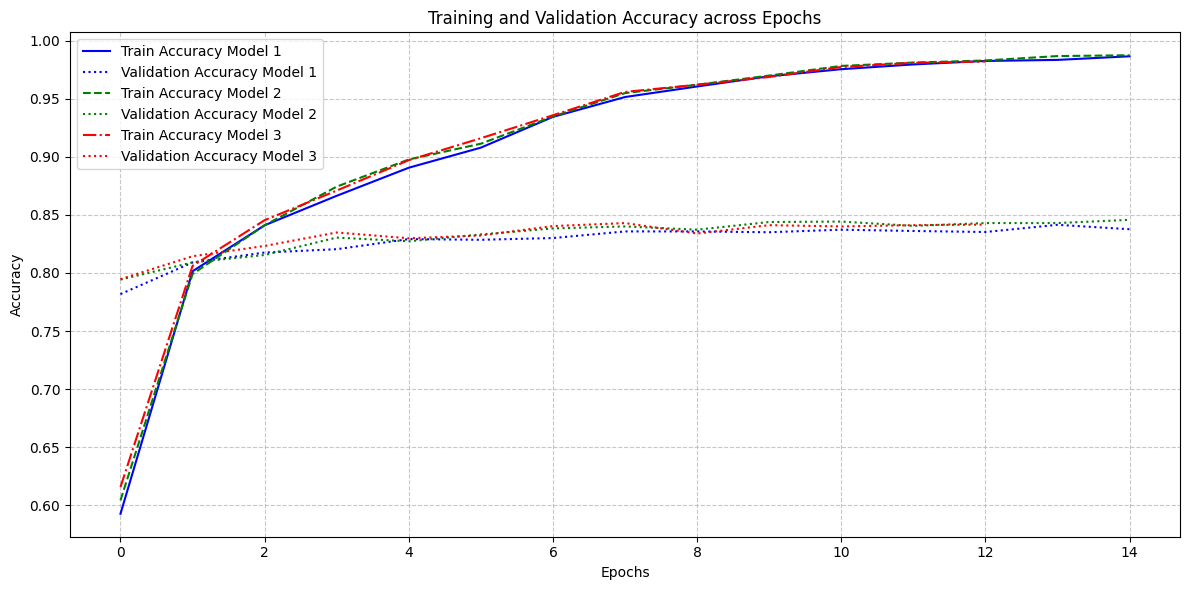

In [ ]:
import matplotlib.pyplot as plt

# Training histories extracted from the console output
histories = [
    {
        'train_accuracy': [0.5925, 0.8015, 0.8411, 0.8665, 0.8907, 0.9080, 0.9345, 0.9516, 0.9607, 0.9695, 0.9756, 0.9797, 0.9827, 0.9836, 0.9867],
        'val_accuracy': [0.7818, 0.8091, 0.8176, 0.8205, 0.8292, 0.8286, 0.8301, 0.8358, 0.8358, 0.8351, 0.8373, 0.8362, 0.8353, 0.8415, 0.8377]
    },
    {
        'train_accuracy': [0.6041, 0.7991, 0.8411, 0.8744, 0.8978, 0.9114, 0.9348, 0.9550, 0.9622, 0.9701, 0.9784, 0.9813, 0.9831, 0.9869, 0.9876],
        'val_accuracy': [0.7943, 0.8091, 0.8155, 0.8305, 0.8273, 0.8332, 0.8384, 0.8401, 0.8373, 0.8439, 0.8443, 0.8406, 0.8430, 0.8430, 0.8458]
    },
    {
        'train_accuracy': [0.6155, 0.8061, 0.8455, 0.8710, 0.8972, 0.9161, 0.9359, 0.9560, 0.9622, 0.9689, 0.9775, 0.9811, 0.9822],
        'val_accuracy': [0.7947, 0.8144, 0.8233, 0.8349, 0.8299, 0.8323, 0.8404, 0.8430, 0.8340, 0.8412, 0.8401, 0.8412, 0.8417]
    }
]

plt.figure(figsize=(12, 6))

colors = ['blue', 'green', 'red']
line_styles = ['-', '--', '-.']

for i, history in enumerate(histories):
    plt.plot(history['train_accuracy'],
             color=colors[i],
             linestyle=line_styles[i],
             label=f'Train Accuracy Model {i+1}')
    plt.plot(history['val_accuracy'],
             color=colors[i],
             linestyle=':',
             label=f'Validation Accuracy Model {i+1}')

plt.title('Training and Validation Accuracy across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Fold 1
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


358/358 ━━━━━━━━━━━━━━━━━━━━ 147s 395ms/step - accuracy: 0.6211 - loss: 1.3819 - val_accuracy: 0.8377 - val_loss: 0.4952 - learning_rate: 0.0010
Epoch 2/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 140s 389ms/step - accuracy: 0.8653 - loss: 0.4640 - val_accuracy: 0.8517 - val_loss: 0.4594 - learning_rate: 0.0010
Epoch 3/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 142s 389ms/step - accuracy: 0.8912 - loss: 0.3984 - val_accuracy: 0.8505 - val_loss: 0.4800 - learning_rate: 0.0010
Epoch 4/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 142s 390ms/step - accuracy: 0.9130 - loss: 0.3685 - val_accuracy: 0.8555 - val_loss: 0.4496 - learning_rate: 0.0010
Epoch 5/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 135s 370ms/step - accuracy: 0.9317 - loss: 0.3102 - val_accuracy: 0.8475 - val_loss: 0.4723 - learning_rate: 0.0010
Epoch 6/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 151s 394ms/step - accuracy: 0.9365 - loss: 0.3012 - val_accuracy: 0.8522 - val_loss: 0.5392 - learning_rate: 0.0010
Epoch 7/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 141s 393ms/step - accuracy: 0.9446 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


358/358 ━━━━━━━━━━━━━━━━━━━━ 144s 384ms/step - accuracy: 0.5140 - loss: 1.4203 - val_accuracy: 0.5236 - val_loss: 0.6934 - learning_rate: 0.0010
Epoch 2/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 140s 391ms/step - accuracy: 0.5201 - loss: 0.6931 - val_accuracy: 0.5236 - val_loss: 0.6921 - learning_rate: 0.0010
Epoch 3/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 143s 396ms/step - accuracy: 0.5223 - loss: 0.6924 - val_accuracy: 0.5236 - val_loss: 0.6920 - learning_rate: 0.0010
Epoch 4/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 137s 383ms/step - accuracy: 0.5269 - loss: 0.6918 - val_accuracy: 0.5236 - val_loss: 0.6920 - learning_rate: 0.0010
Epoch 5/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 147s 396ms/step - accuracy: 0.5250 - loss: 0.6920 - val_accuracy: 0.5236 - val_loss: 0.6921 - learning_rate: 0.0010
Epoch 6/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 139s 389ms/step - accuracy: 0.5232 - loss: 0.6921 - val_accuracy: 0.5236 - val_loss: 0.6920 - learning_rate: 5.0000e-04
179/179 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step

Classification Report:
     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src

358/358 ━━━━━━━━━━━━━━━━━━━━ 140s 374ms/step - accuracy: 0.5162 - loss: 1.4200 - val_accuracy: 0.5236 - val_loss: 0.6935 - learning_rate: 0.0010
Epoch 2/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 141s 372ms/step - accuracy: 0.5204 - loss: 0.6932 - val_accuracy: 0.5236 - val_loss: 0.6922 - learning_rate: 0.0010
Epoch 3/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 141s 370ms/step - accuracy: 0.5274 - loss: 0.6918 - val_accuracy: 0.5236 - val_loss: 0.6921 - learning_rate: 0.0010
Epoch 4/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 130s 364ms/step - accuracy: 0.5207 - loss: 0.6924 - val_accuracy: 0.5236 - val_loss: 0.6920 - learning_rate: 0.0010
Epoch 5/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 133s 371ms/step - accuracy: 0.5241 - loss: 0.6920 - val_accuracy: 0.5236 - val_loss: 0.6920 - learning_rate: 0.0010
Epoch 6/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 142s 371ms/step - accuracy: 0.5185 - loss: 0.6925 - val_accuracy: 0.5236 - val_loss: 0.6921 - learning_rate: 0.0010
179/179 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step

Classification Report:
        

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src

358/358 ━━━━━━━━━━━━━━━━━━━━ 143s 385ms/step - accuracy: 0.5213 - loss: 1.4243 - val_accuracy: 0.5236 - val_loss: 0.6946 - learning_rate: 0.0010
Epoch 2/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 140s 380ms/step - accuracy: 0.5234 - loss: 0.6937 - val_accuracy: 0.5236 - val_loss: 0.6923 - learning_rate: 0.0010
Epoch 3/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 139s 372ms/step - accuracy: 0.5289 - loss: 0.6918 - val_accuracy: 0.5236 - val_loss: 0.6921 - learning_rate: 0.0010
Epoch 4/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 142s 371ms/step - accuracy: 0.5228 - loss: 0.6922 - val_accuracy: 0.5236 - val_loss: 0.6921 - learning_rate: 0.0010
Epoch 5/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 136s 381ms/step - accuracy: 0.5267 - loss: 0.6919 - val_accuracy: 0.5236 - val_loss: 0.6921 - learning_rate: 0.0010
Epoch 6/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 144s 387ms/step - accuracy: 0.5239 - loss: 0.6920 - val_accuracy: 0.5236 - val_loss: 0.6920 - learning_rate: 0.0010
179/179 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step

Classification Report:
         

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src

358/358 ━━━━━━━━━━━━━━━━━━━━ 142s 383ms/step - accuracy: 0.5522 - loss: 1.4089 - val_accuracy: 0.8233 - val_loss: 0.7993 - learning_rate: 0.0010
Epoch 2/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 141s 380ms/step - accuracy: 0.7928 - loss: 0.6187 - val_accuracy: 0.8342 - val_loss: 0.4902 - learning_rate: 0.0010
Epoch 3/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 138s 385ms/step - accuracy: 0.8664 - loss: 0.4533 - val_accuracy: 0.8403 - val_loss: 0.4681 - learning_rate: 0.0010
Epoch 4/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 141s 384ms/step - accuracy: 0.8957 - loss: 0.3877 - val_accuracy: 0.8494 - val_loss: 0.4640 - learning_rate: 0.0010
Epoch 5/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 148s 414ms/step - accuracy: 0.9162 - loss: 0.3466 - val_accuracy: 0.8513 - val_loss: 0.4670 - learning_rate: 0.0010
Epoch 6/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 189s 378ms/step - accuracy: 0.9304 - loss: 0.3173 - val_accuracy: 0.8448 - val_loss: 0.5169 - learning_rate: 0.0010
Epoch 7/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 143s 382ms/step - accuracy: 0.9324 

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.

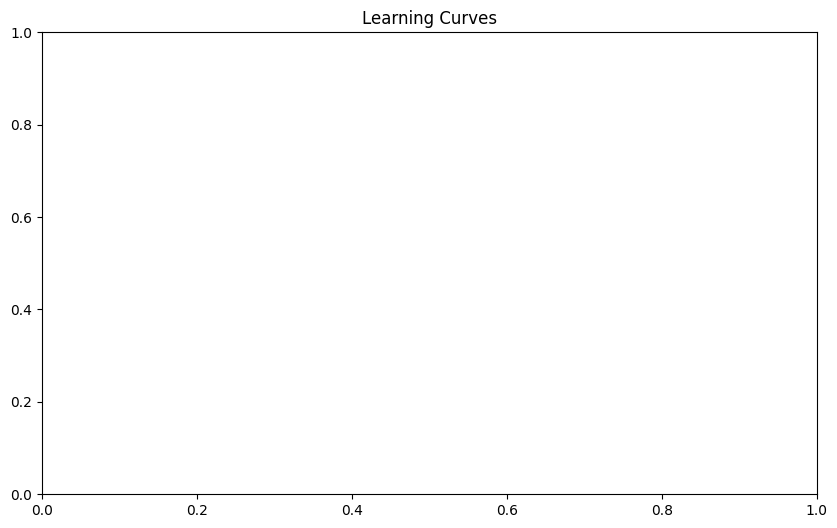

In [ ]:
###overfitting removed
import json
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, GlobalMaxPooling1D, Conv1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Advanced Data Preprocessing
def preprocess_data(max_words=10000, maxlen=100):
    # Load data
    with open('Sarcasm_Headlines_Dataset.json') as f:
        data = [json.loads(line) for line in f]

    df = pd.DataFrame(data)
    df = df[['headline', 'is_sarcastic']]

    # Tokenization with more advanced settings
    tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
    tokenizer.fit_on_texts(df['headline'])

    # Convert to sequences with more careful padding
    sequences = tokenizer.texts_to_sequences(df['headline'])
    X = pad_sequences(sequences, maxlen=maxlen, truncating='post', padding='post')
    y = df['is_sarcastic'].values

    return X, y, tokenizer

# Advanced Model Architecture
def create_advanced_model(input_shape, vocab_size):
    model = Sequential([
        # Embedding layer with regularization
        Embedding(vocab_size, 128, input_length=input_shape[1],
                  embeddings_regularizer=l2(0.001)),

        # Bidirectional LSTM with dropout and regularization
        Bidirectional(LSTM(64, return_sequences=True,
                           kernel_regularizer=l2(0.001),
                           recurrent_regularizer=l2(0.001))),

        # Convolutional layer for additional feature extraction
        Conv1D(64, 5, activation='relu',
               kernel_regularizer=l2(0.001)),
        GlobalMaxPooling1D(),

        # Multiple dense layers with dropout
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.4),

        # Output layer
        Dense(1, activation='sigmoid')
    ])

    # Advanced optimizer with learning rate scheduling
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Cross-Validation Function
def cross_validation_training(X, y, n_splits=5):
    # Stratified K-Fold to ensure balanced class distribution
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Store results for each fold
    cv_scores = []

    # Learning curves to track
    train_losses = []
    val_losses = []

    # Iterate through folds
    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        print(f"\nFold {fold}")

        # Split data
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Create model
        vocab_size = len(tokenizer.word_index) + 1
        model = create_advanced_model(X_train.shape, vocab_size)

        # Early stopping and learning rate reduction
        early_stop = tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            restore_best_weights=True
        )

        lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3
        )

        # Train model
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=20,
            batch_size=64,
            callbacks=[early_stop, lr_reduce],
            verbose=1
        )

        # Evaluate model
        val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
        cv_scores.append(val_acc)

        # Store learning curves
        train_losses.append(history.history['loss'])
        val_losses.append(history.history['val_loss'])

        # Detailed classification report
        y_pred = (model.predict(X_val) > 0.5).astype(int)
        print("\nClassification Report:")
        print(classification_report(y_val, y_pred))

    # Print cross-validation results
    print("\nCross-Validation Results:")
    print(f"Mean Accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")

    # Visualization of learning curves
    plt.figure(figsize=(10, 6))
    plt.title("Learning Curves")
    plt.plot(np.mean(train_losses, axis=0), label='Training Loss')
    plt.plot(np.mean(val_losses, axis=0), label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Main Execution
# Load and preprocess data
X, y, tokenizer = preprocess_data()

# Perform cross-validation training
cross_validation_training(X, y)